# Style transfer

 - **Step1**:  Create `Target image` as random number and make it trainable.

 - **Step2**:  Pick pre-trained CNN network.

 - **Step3**:  Match target image with `content image` (pixel level) using the activation maps early in network we can use the latest layers but it preferable to use the earliest cz the latest learn abstract features. If we stopped on `step3` after a bench of iterations the target image will look like the content image therefore we go to step 4 to match the style.

 - **Step4**: Here we interested to match the `Gramme matrices` that encode the high relationships accross the different pixels and that's what give us the texture or the style images and not the individual pixel density values.

Mainly style transfer done on two main stages:

### Preparation

 - Import and freez pretrained CNN.

 - Import and transform images (transorm usually to reszie cz style transfer take long time).

 - Create trainable target image using random numbers.

 - Create functions to compute features maps and Gram matrices.

### Training

 - Push the `target` and `content` images throw the CNN model in order to extract the activation maps from the layers that we want to train.

 - Calculate MSE target activation maps vs content activation maps. (we want to match pixels images)

 - Calculate Gram matrices of target and style feartures maps.

 - Calculate Style MSE target Gram vs style Gram.

 - Loss = Content MSE + Style MSE.

 - BackProp on target image.


In [68]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data  import DataLoader,TensorDataset,Subset
import copy 
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

# Import VGG19 and freez all layers

In [69]:
from torchvision.models import VGG19_Weights
vggnet = torchvision.models.vgg19(weights=VGG19_Weights.DEFAULT)

In [70]:
for p in vggnet.parameters():
    p.requires_grad_(False)

In [71]:
vggnet.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [72]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [73]:
vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [99]:
from imageio import imread
img4content = imread('https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Grande_Mosqu%C3%A9e_de_Tlemcen.jpg/960px-Grande_Mosqu%C3%A9e_de_Tlemcen.jpg')
img4style = imread('https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/960px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)
img4content.shape , img4style.shape , img4target.shape

/var/folders/tn/ydlwf6sn6bb5ccy1g888k1q40000gn/T/ipykernel_5602/3377420580.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread('https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Grande_Mosqu%C3%A9e_de_Tlemcen.jpg/960px-Grande_Mosqu%C3%A9e_de_Tlemcen.jpg')
/var/folders/tn/ydlwf6sn6bb5ccy1g888k1q40000gn/T/ipykernel_5602/3377420580.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style = imread('https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/960px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.

((640, 960, 3), (760, 960, 3), (640, 960, 3))

In [75]:
Ts = T.Compose(
    [
        T.ToTensor(),
        T.Resize(256),
        T.Normalize(
            mean=[.485,.456,.406],
            std=[.229,.224,.225]
        )
    ]
)

In [76]:
img4content = Ts(img4content).unsqueeze(0).to(device) # add dimension which is batch dimension
img4style = Ts(img4style).unsqueeze(0).to(device)
img4target = Ts(img4target).unsqueeze(0).to(device)

In [77]:
img4content.shape

torch.Size([1, 3, 256, 384])

In [78]:
vggnet.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [79]:
def getFeaturesMapsAct(img,net):
    featuresMaps = []
    featuresNames = []
    convLayerIdx = 0

    for layerNum in range(len(net.features)):
        
        img = net.features[layerNum](img)

        if 'Conv2d' in str(net.features[layerNum]):
            featuresMaps.append(img)
            featuresNames.append(f'ConvLayer_{convLayerIdx}')
            convLayerIdx +=1

    return featuresMaps,featuresNames        

In [80]:
# function that return the gram matrix of an activation map
def gramMatrix(M):
  # reshape to 2D
  _,c,h,w = M.shape
  M = M.reshape(c,h*w)
  gram = torch.mm(M,M.t()) / (c*h*w)

  return gram

In [81]:
contentFeatuesMaps,contentFeaturesNames = getFeaturesMapsAct(img4content,vggnet)

for i in range(len(contentFeaturesNames)):
    print(f'Feature map {contentFeaturesNames[i]} his size is {contentFeatuesMaps[i].shape}')

Feature map ConvLayer_0 his size is torch.Size([1, 64, 256, 384])
Feature map ConvLayer_1 his size is torch.Size([1, 64, 256, 384])
Feature map ConvLayer_2 his size is torch.Size([1, 128, 128, 192])
Feature map ConvLayer_3 his size is torch.Size([1, 128, 128, 192])
Feature map ConvLayer_4 his size is torch.Size([1, 256, 64, 96])
Feature map ConvLayer_5 his size is torch.Size([1, 256, 64, 96])
Feature map ConvLayer_6 his size is torch.Size([1, 256, 64, 96])
Feature map ConvLayer_7 his size is torch.Size([1, 256, 64, 96])
Feature map ConvLayer_8 his size is torch.Size([1, 512, 32, 48])
Feature map ConvLayer_9 his size is torch.Size([1, 512, 32, 48])
Feature map ConvLayer_10 his size is torch.Size([1, 512, 32, 48])
Feature map ConvLayer_11 his size is torch.Size([1, 512, 32, 48])
Feature map ConvLayer_12 his size is torch.Size([1, 512, 16, 24])
Feature map ConvLayer_13 his size is torch.Size([1, 512, 16, 24])
Feature map ConvLayer_14 his size is torch.Size([1, 512, 16, 24])
Feature map Co

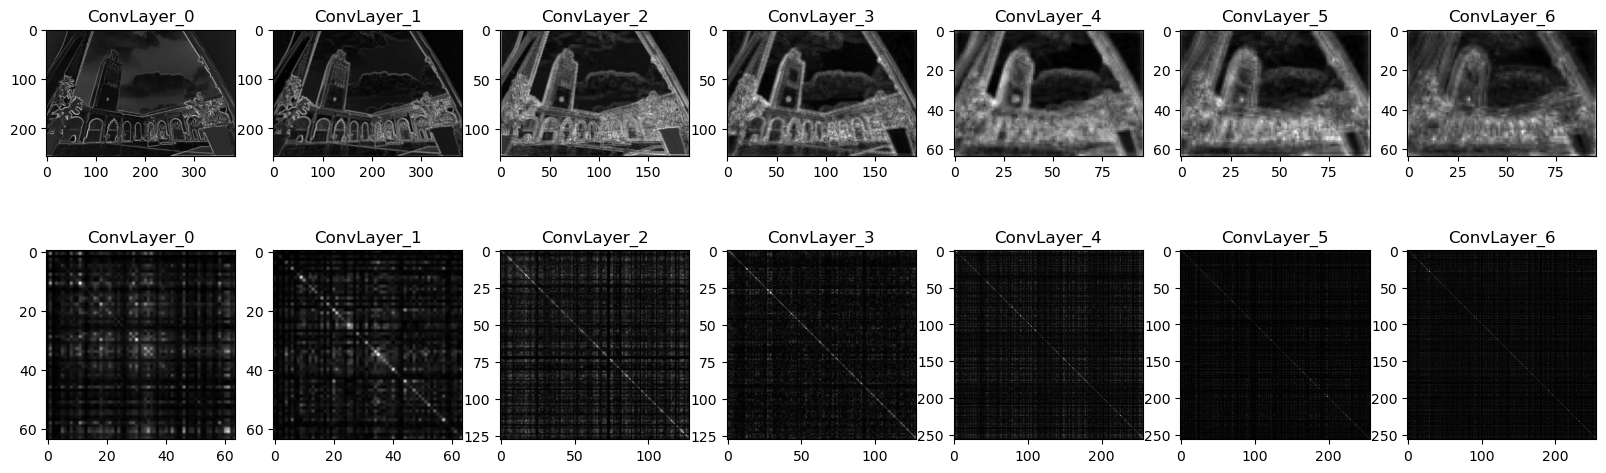

In [82]:
fig,axs = plt.subplots(2,7,figsize=(20,6))

for i in range(7):

    # average over all feature maps form this layer and normalize
    pic = np.mean(contentFeatuesMaps[i].cpu().squeeze().numpy(),axis=0)
    pic = (pic-np.min(pic))/(np.max(pic)-np.min(pic))
    
    axs[0,i].imshow(pic,cmap='gray')
    axs[0,i].set_title(contentFeaturesNames[i])

    # show the gram matrix
    axs[1,i].imshow(gramMatrix(contentFeatuesMaps[i]).cpu().squeeze().numpy(),cmap='gray')
    axs[1,i].set_title(contentFeaturesNames[i])


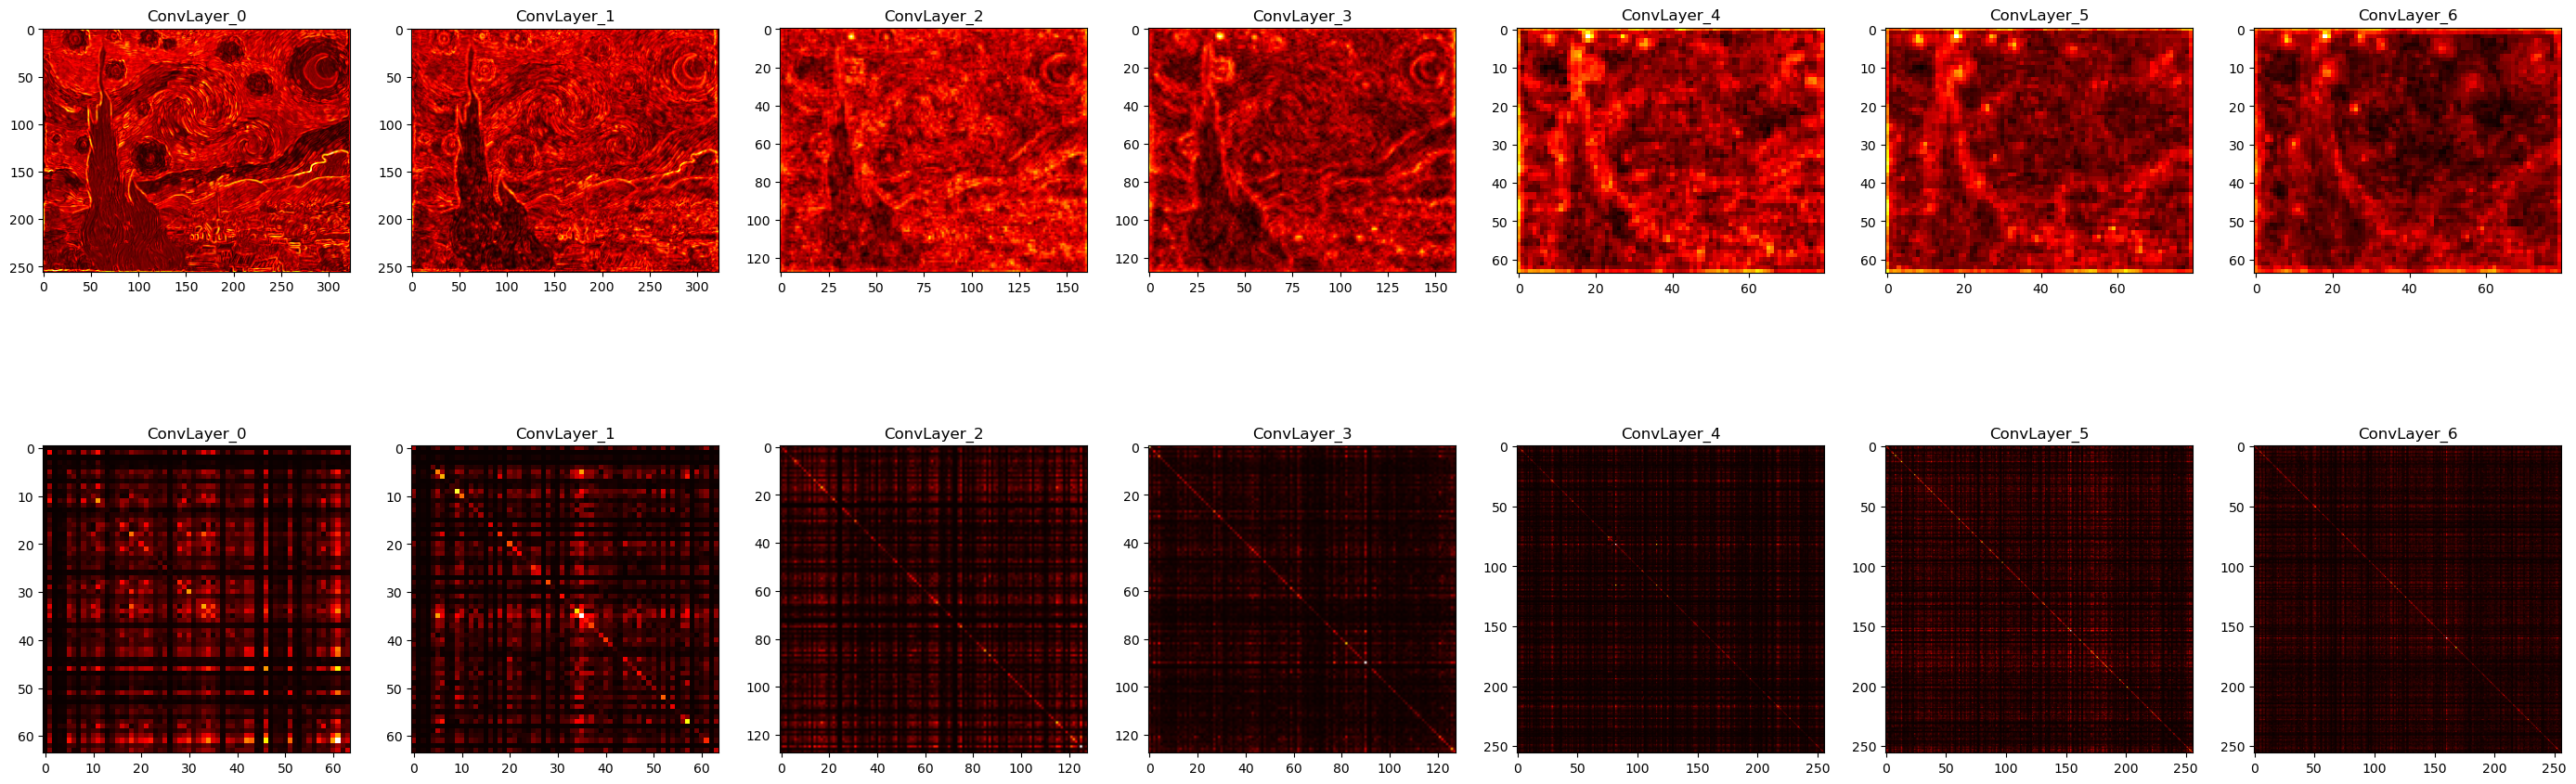

In [83]:
styleFeatuesMaps, styleFeaturesNames = getFeaturesMapsAct(img4style, vggnet)

fig, axs = plt.subplots(2, 7, figsize=(35, 12))  # Make the whole figure bigger
fig.subplots_adjust(wspace=0.2, hspace=0.1)     # Reduce space between plots

for i in range(7):
    # Average feature maps and normalize
    pic = np.mean(styleFeatuesMaps[i].cpu().squeeze().numpy(), axis=0)
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[0, i].imshow(pic, cmap='hot')
    axs[0, i].set_title(styleFeaturesNames[i], fontsize=12)

    gram = gramMatrix(styleFeatuesMaps[i]).cpu().squeeze().numpy()
    axs[1, i].imshow(gram, cmap='hot')
    axs[1, i].set_title(styleFeaturesNames[i], fontsize=12)

# Transfer

In [94]:
# meta params
layers4content = ['ConvLayer_1','ConvLayer_4']
layers4style = ['ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5']
weight4style =  [1,.5,.5,.2,.1] 

In [95]:
target = img4target.clone()
target.requires_grad = True
target.to(device)
styleScaling = 1e6 # the error term of content transfer and style transfer are numerically very different so we need to scale up the loss fun of the style to make them comparable

numberEpochs = 1500
optimizer = torch.optim.RMSprop([target], lr=0.001) # recommended by the original paper

for epoch in range(numberEpochs):

    # extract the target feature maps
    targetFeatuesMaps,targetFeaturesNames = getFeaturesMapsAct(target,vggnet)

    # initialize individual losses
    styleLoss = 0
    contentLoss = 0

    for layer in range(len(targetFeaturesNames)):

        # compute the content loss
        if targetFeaturesNames[layer] in layers4content:
            contentLoss += torch.mean((targetFeatuesMaps[layer] - contentFeatuesMaps[layer])**2) # mse loss


        # compute the style loss
        if targetFeaturesNames[layer] in layers4style:
            gTarget = gramMatrix(targetFeatuesMaps[layer])
            gStyle = gramMatrix(styleFeatuesMaps[layer])

            # compute their loss de-weighted with increasing depth
            styleLoss += torch.mean((gTarget - gStyle)**2) * weight4style[layers4style.index(targetFeaturesNames[layer])]

    combinedLoss = styleScaling * styleLoss + contentLoss

    optimizer.zero_grad()
    combinedLoss.backward()
    optimizer.step()        

Text(0.5, 1.0, 'Target')

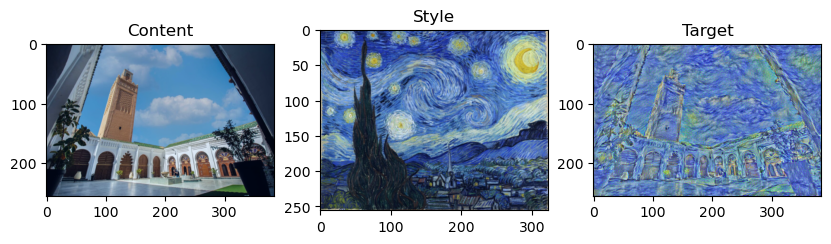

In [96]:
fig,ax = plt.subplots(1,3,figsize=(10,10))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic))/(np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic))/(np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Style')

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic))/(np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Target')
